In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


# Load the datasets
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_test-set.csv')

#Display the first few rows
print(train_data.head())
print(test_data.head())



   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

In [4]:
#check for missing null value
print(train_data.isnull().sum())
print(test_data.isnull().sum())


id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [10]:
# Split the data into features (X) and labels (y)
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training features shape: (175341, 44)
Training labels shape: (175341,)
Testing features shape: (82332, 44)
Testing labels shape: (82332,)


In [11]:
# Define the categorical columns
categorical_columns = ['proto', 'service', 'state', 'attack_cat']

# Remove rows with categorical values not common in both training and test data
for column in categorical_columns:
    train_unique = set(train_data[column].unique())
    test_unique = set(test_data[column].unique())
    
    common_values = train_unique.intersection(test_unique)
    
    # Filter the training and test sets based on common values
    train_data = train_data[train_data[column].isin(common_values)]
    test_data = test_data[test_data[column].isin(common_values)]

# Check if the number of rows has been reduced after filtering
print(f"Number of rows in the training set: {len(train_data)}")
print(f"Number of rows in the test set: {len(test_data)}")


Number of rows in the training set: 175325
Number of rows in the test set: 82327


In [13]:
# Handle Categorical Value (based on the project categorical values in training data may not match those in the test data
# Find unique categorical Values

categorical_columns = train_data.select_dtypes(include=['object']).columns
print(categorical_columns)

for col in categorical_columns:
    print(f'{col} unique values in training set: {train_data[col].unique()}')
    print(f'{col} unique values in test set: {test_data[col].unique()}')


Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')
proto unique values in training set: ['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp

In [13]:
# Store the initial number of rows before dropping missing values
initial_train_rows = len(train_data)
initial_test_rows = len(test_data)

# Drop rows with missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Store the final number of rows after dropping missing values
final_train_rows = len(train_data)
final_test_rows = len(test_data)

# Print how many rows were dropped due to missing values
print(f"Training set: {initial_train_rows - final_train_rows} rows were dropped due to missing values.")
print(f"Testing set: {initial_test_rows - final_test_rows} rows were dropped due to missing values.")



Training set: 0 rows were dropped due to missing values.
Testing set: 0 rows were dropped due to missing values.


In [14]:
# Encode Categorical Feature(requirement)

# Categorical columns to be encoded
categorical_columns = ['proto', 'service', 'state', 'attack_cat']

# One-hot encode categorical features in the training data
train_data = pd.get_dummies(train_data, columns=categorical_columns)

# One-hot encode categorical features in the testing data
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Ensure that both datasets have the same columns after encoding
train_data, test_data = train_data.align(test_data, join='inner', axis=1)

print("Categorical features encoded successfully.")
print("Training data shape after encoding:", train_data.shape)
print("Testing data shape after encoding:", test_data.shape)



Categorical features encoded successfully.
Training data shape after encoding: (175325, 200)
Testing data shape after encoding: (82327, 200)


In [15]:
#Normalize the Numerical Feature
from scipy.stats import zscore

# List of columns that are numerical (exclude the label and any encoded categorical columns)
numerical_columns = train_data.select_dtypes(include=[np.number]).columns.difference(['label'])

# Apply z-score normalization
train_data[numerical_columns] = train_data[numerical_columns].apply(zscore)
test_data[numerical_columns] = test_data[numerical_columns].apply(zscore)

# Check the normalized data
print(train_data.head())
print(test_data.head())


         id       dur     spkts     dpkts    sbytes    dbytes      rate  \
0 -1.732236 -0.191040 -0.104463 -0.135778 -0.049136 -0.102730 -0.576362   
1 -1.732216 -0.109499 -0.046024  0.172576 -0.046412  0.188526 -0.576335   
2 -1.732196  0.040678 -0.089853 -0.026948 -0.048529 -0.012142 -0.576724   
3 -1.732177  0.049707 -0.060633 -0.063225 -0.047019 -0.098568 -0.576727   
4 -1.732157 -0.140430 -0.075243 -0.117640 -0.047556 -0.102062 -0.576608   

       sttl      dttl     sload  ...  attack_cat_Analysis  \
0  0.703781  1.578000 -0.389871  ...                False   
1 -1.141967  1.559902 -0.389902  ...                False   
2 -1.141967  1.559902 -0.389938  ...                False   
3 -1.141967  1.559902 -0.389932  ...                False   
4  0.723210  1.559902 -0.389901  ...                False   

   attack_cat_Backdoor  attack_cat_DoS  attack_cat_Exploits  \
0                False           False                False   
1                False           False                Fa

In [17]:
# Split the training set into features and labels
X_train = train_data.drop('label', axis=1)  # Features
y_train = train_data['label']                 # Labels

# Split the testing set into features and labels
X_test = test_data.drop('label', axis=1)     # Features
y_test = test_data['label']                   # Labels

# Display the shapes of the new datasets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)



Training data shape: (175325, 199) (175325,)
Testing data shape: (82327, 199) (82327,)


In [19]:

# Check the actual column names
print("Training feature columns:", X_train.columns.tolist())
print("Testing feature columns:", X_test.columns.tolist())



Training feature columns: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'p

In [24]:
# Update this list with actual categorical column names from your dataset
categorical_columns = [
    'proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus',
    'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna',
    'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 
    'service_-', 'service_dhcp', 'service_dns', 'service_ftp', 
    'state_CON', 'state_FIN', 'state_INT', 'attack_cat_Analysis', 
    'attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
    'attack_cat_Fuzzers', 'attack_cat_Generic', 'attack_cat_Normal',
    'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms'
]


In [25]:
# Remove records with unique categorical values in training or test sets
for column in categorical_columns:
    # Get unique values in training and test sets
    unique_values_training = set(X_train[column].unique())
    unique_values_test = set(X_test[column].unique())

    # Find common values
    common_values = unique_values_training.intersection(unique_values_test)

    # Filter out records not in common values
    X_train = X_train[X_train[column].isin(common_values)]
    X_test = X_test[X_test[column].isin(common_values)]


In [26]:
#Verify if any rows were removed.

# Print shapes before filtering
print("Before filtering:")
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# (Your filtering code goes here)

# Print shapes after filtering
print("After filtering:")
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Before filtering:
Training data shape: (175325, 199)
Testing data shape: (82327, 199)
After filtering:
Training data shape: (175325, 199)
Testing data shape: (82327, 199)


In [27]:
# double check the column names in x-train and  x-test 

# Display the first few rows and the columns of the training and testing datasets
print("Training dataset columns:")
print(X_train.columns.tolist())

print("\nTesting dataset columns:")
print(X_test.columns.tolist())

print("\nTraining dataset preview:")
print(X_train.head())

print("\nTesting dataset preview:")
print(X_test.head())


Training dataset columns:
['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'p

In [29]:
# Filter categorical values that do not match between training and testing datasets
for col in categorical_columns:
    train_unique_values = set(X_train[col].unique())
    test_unique_values = set(X_test[col].unique())
    # Keep only the rows with values present in both datasets
    X_train = X_train[X_train[col].isin(test_unique_values)]
    X_test = X_test[X_test[col].isin(train_unique_values)]

# Drop any rows with missing values
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Encode categorical features using one-hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align columns in training and testing datasets to handle any discrepancies
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Normalize numeric features (example using MinMaxScaler)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Display the shapes of the processed datasets
print("Processed Training data shape:", X_train.shape)
print("Processed Testing data shape:", X_test.shape)

# Display the first few rows of the processed datasets
print("\nProcessed Training dataset preview:")
print(X_train.head())

print("\nProcessed Testing dataset preview:")
print(X_test.head())



Processed Training data shape: (175325, 199)
Processed Testing data shape: (82327, 199)

Processed Training dataset preview:
         id       dur     spkts     dpkts    sbytes    dbytes      rate  \
0  0.000000  0.002025  0.000520  0.000364  0.000016  0.000012  0.000074   
1  0.000006  0.010832  0.001352  0.003463  0.000053  0.002867  0.000078   
2  0.000011  0.027052  0.000728  0.001458  0.000025  0.000900  0.000014   
3  0.000017  0.028027  0.001144  0.001093  0.000045  0.000053  0.000014   
4  0.000023  0.007491  0.000936  0.000547  0.000038  0.000018  0.000033   

       sttl      dttl         sload  ...  attack_cat_Analysis_True  \
0  0.988235  1.000000  2.364553e-06  ...                     False   
1  0.243137  0.992126  1.401989e-06  ...                     False   
2  0.243137  0.992126  2.625704e-07  ...                     False   
3  0.243137  0.992126  4.576117e-07  ...                     False   
4  0.996078  0.992126  1.429776e-06  ...                     False   

   

In [30]:
# Sample code for Model Architecture
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(activation='relu'):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Add hidden layers (adjust number of layers and neurons as needed)
    model.add(layers.Dense(64, activation=activation))
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(16, activation=activation))

    # Output layer (adjust the number of neurons based on the number of classes)
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Display the model summary
model.summary()


C:\Users\Admin\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,425 (60.25 KB)

 Trainable params: 15,425 (60.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint])



Epoch 1/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9899 - loss: 0.0341 - val_accuracy: 1.0000 - val_loss: 1.7326e-07
Epoch 2/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 4.5822e-07 - val_accuracy: 1.0000 - val_loss: 9.6136e-09
Epoch 3/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 3.2531e-08 - val_accuracy: 1.0000 - val_loss: 1.2917e-09
Epoch 4/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 1.0000 - loss: 4.7993e-09 - val_accuracy: 1.0000 - val_loss: 4.3837e-10
Epoch 5/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 1.4868e-09 - val_accuracy: 1.0000 - val_loss: 2.1852e-10
Epoch 6/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 7.0118e-10 - val_accuracy: 1.0000 - val_loss: 1.4178e-10
Epoch 7/100
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 1.0000 - loss: 4.5402e-10 - val_accuracy: 1.0000 - val_loss: 1.0199e-10
Epoch 8/100
4384/4384 ━━━━━━━━━

In [33]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



2573/2573 ━━━━━━━━━━━━━━━━━━━━ 2s 725us/step - accuracy: 1.0000 - loss: 2.6186e-09
Test Loss: 0.0000
Test Accuracy: 1.0000


In [34]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Adjust threshold based on your requirements


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 2s 661us/step


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36998
           1       1.00      1.00      1.00     45329

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327

Confusion Matrix:
[[36998     0]
 [    0 45329]]


In [36]:
# Save the final model
model.save('final_model.keras')


In [38]:
print(train_data.columns)
print(test_data.columns)



Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=200)
Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=200)


In [39]:
# Choose the categorical column you want to analyze
category_column = 'attack_cat_DoS'  # Change this to your desired column name

# Find unique values in the categorical column for training and test data
train_categorical_values = set(train_data[category_column].unique())
test_categorical_values = set(test_data[category_column].unique())

# Find values unique to training and test data
train_only = train_categorical_values - test_categorical_values
test_only = test_categorical_values - train_categorical_values

# Drop rows with those unique values from training and test data
train_data = train_data[~train_data[category_column].isin(train_only)]
test_data = test_data[~test_data[category_column].isin(test_only)]

# Optional: Check the resulting datasets
print(f"Training data shape after dropping unmatched categories: {train_data.shape}")
print(f"Test data shape after dropping unmatched categories: {test_data.shape}")


Training data shape after dropping unmatched categories: (175325, 200)
Test data shape after dropping unmatched categories: (82327, 200)


In [40]:
# Drop rows with missing values in both training and test datasets
train_data = train_data.dropna()
test_data = test_data.dropna()

# Check the shapes of the datasets after dropping missing values
print(f"Training data shape after dropping missing values: {train_data.shape}")
print(f"Test data shape after dropping missing values: {test_data.shape}")


Training data shape after dropping missing values: (175325, 200)
Test data shape after dropping missing values: (82327, 200)


In [41]:
# List of categorical columns to encode 
categorical_columns = [col for col in train_data.columns if 'attack_cat_' in col]

# One-hot encode categorical features for both datasets
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns)

# Ensure both datasets have the same columns after encoding
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='outer', axis=1, fill_value=0)

# Check the shapes of the encoded datasets
print(f"Training data shape after encoding: {train_data_encoded.shape}")
print(f"Test data shape after encoding: {test_data_encoded.shape}")


Training data shape after encoding: (175325, 210)
Test data shape after encoding: (82327, 210)


In [42]:
# Identify categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns

# Encode categorical features for both training and test datasets
train_data_encoded = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)

# Ensure the columns match in both datasets
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='outer', axis=1, fill_value=0)

# Display the shapes of the new datasets
print("Training data shape after encoding: ", train_data_encoded.shape)
print("Test data shape after encoding: ", test_data_encoded.shape)


Training data shape after encoding:  (175325, 200)
Test data shape after encoding:  (82327, 200)


In [43]:
from sklearn.preprocessing import StandardScaler

# Separate the numeric columns
numeric_cols = train_data_encoded.select_dtypes(include=['int64', 'float64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both datasets
train_data_encoded[numeric_cols] = scaler.fit_transform(train_data_encoded[numeric_cols])
test_data_encoded[numeric_cols] = scaler.transform(test_data_encoded[numeric_cols])

# Display the first few rows of the encoded and normalized training data
print(train_data_encoded.head())


         id       dur     spkts     dpkts    sbytes    dbytes      rate  \
0 -1.732236 -0.191040 -0.104463 -0.135778 -0.049136 -0.102730 -0.576362   
1 -1.732216 -0.109499 -0.046024  0.172576 -0.046412  0.188526 -0.576335   
2 -1.732196  0.040678 -0.089853 -0.026948 -0.048529 -0.012142 -0.576724   
3 -1.732177  0.049707 -0.060633 -0.063225 -0.047019 -0.098568 -0.576727   
4 -1.732157 -0.140430 -0.075243 -0.117640 -0.047556 -0.102062 -0.576608   

       sttl      dttl     sload  ...  attack_cat_Analysis  \
0  0.703781  1.578000 -0.389871  ...                False   
1 -1.141967  1.559902 -0.389902  ...                False   
2 -1.141967  1.559902 -0.389938  ...                False   
3 -1.141967  1.559902 -0.389932  ...                False   
4  0.723210  1.559902 -0.389901  ...                False   

   attack_cat_Backdoor  attack_cat_DoS  attack_cat_Exploits  \
0                False           False                False   
1                False           False                Fa

In [44]:
# Drop any rows with missing values in the encoded training and test datasets
train_data_cleaned = train_data_encoded.dropna()
test_data_cleaned = test_data_encoded.dropna()

# Display the shapes after dropping missing values
print("Training data shape after dropping missing values: ", train_data_cleaned.shape)
print("Test data shape after dropping missing values: ", test_data_cleaned.shape)


Training data shape after dropping missing values:  (175325, 200)
Test data shape after dropping missing values:  (82327, 200)


In [46]:
# Check the column names in the cleaned training and test datasets
print("Training data columns:", train_data_cleaned.columns.tolist())
print("Test data columns:", test_data_cleaned.columns.tolist())



Training data columns: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nls

In [47]:
# Print the training and test data columns
print("Training data columns:", train_data_cleaned.columns.tolist())
print("Test data columns:", test_data_cleaned.columns.tolist())

# Set the correct label column name
label_column_name = 'label'  # Use 'label' based on your column names

# Separate features and labels
X_train = train_data_cleaned.drop(columns=[label_column_name])
y_train = train_data_cleaned[label_column_name]
X_test = test_data_cleaned.drop(columns=[label_column_name])
y_test = test_data_cleaned[label_column_name]

# Display the shapes of the features and labels
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Training data columns: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nls

In [48]:
#Import Required Libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt


In [49]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert probabilities to binary predictions if your model outputs probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # Use the appropriate threshold


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step


In [51]:
# Check the Shape of Your Data
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_classes:", y_pred_classes.shape)



Shape of y_test: (82327,)
Shape of y_pred_classes: (82327, 1)


In [52]:
#Inspect the Values
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))


Unique values in y_test: [-1.46003368  0.68491571]
Unique values in y_pred_classes: [0 1]


In [53]:
# Ensure Binary Predictions
# Make sure this step is correctly implemented
y_pred_classes = (y_pred > 0.5).astype(int)


In [55]:

# If you haven't done this, convert predictions to binary class labels
threshold = 0.5
y_pred_classes = (y_pred > threshold).astype(int)



In [57]:
print("Predicted Classes:", y_pred_classes)
print("True Classes:", y_test)


Predicted Classes: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
True Classes: 0       -1.460034
1       -1.460034
2       -1.460034
3       -1.460034
4       -1.460034
           ...   
82327   -1.460034
82328   -1.460034
82329   -1.460034
82330   -1.460034
82331   -1.460034
Name: label, Length: 82327, dtype: float64


In [58]:
# Check the unique values in y_test
print("Unique values in y_test:", y_test.unique())


Unique values in y_test: [-1.46003368  0.68491571]


In [62]:
# Apply tolerance-based mapping
y_test_binary = y_test.apply(lambda x: 0 if abs(x - (-1.46003368)) < 1e-5 else 1 if abs(x - 0.68491571) < 1e-5 else None)

# Check the mapped values
print("Mapped values in y_test_binary:", y_test_binary.unique())



Mapped values in y_test_binary: [0 1]


In [63]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[30477  6521]
 [  927 44402]]


In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

# Print the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Precision: 0.871943915323135
Recall: 0.9795495157625361
F1-Score: 0.9226197897186552


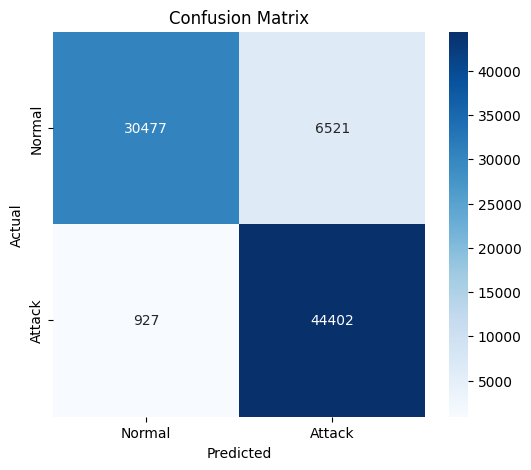

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step


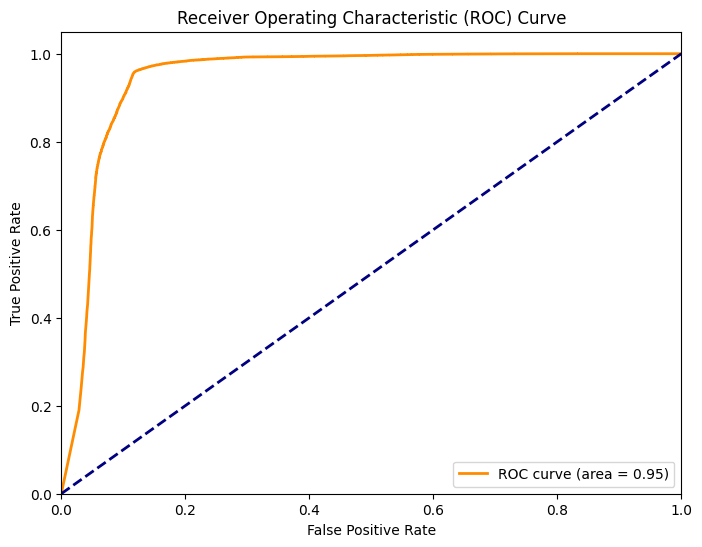

In [66]:
from sklearn.metrics import roc_curve, auc

# Get the probability predictions
y_pred_prob = model.predict(X_test)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
